#Analysis Goals

###Objective
####By leveraging the POI dataset from [OpenBioMechanics](https://www.openbiomechanics.org), which contains key biomechanical markers for pitchers, this project aims to determine if there is a correlation between pitch speed and shoulder energy transfer using Linear regression. Specifically, we want to investigate whether higher shoulder energy transfer is associated with increased pitch velocity.

###Validation
####To ensure our findings are robust, we will validate the results using Pearson correlation, and bootstrap analyses to establish confidence intervals.

###Application
####Beyond establishing a relationship between these variables, the project will further identify "inefficient" pitches—instances where high shoulder energy transfer does not correspond to the expected pitch speed. Such inefficiencies may indicate mechanical issues that could lead to reduced performance or increased risk of overuse injuries over time.


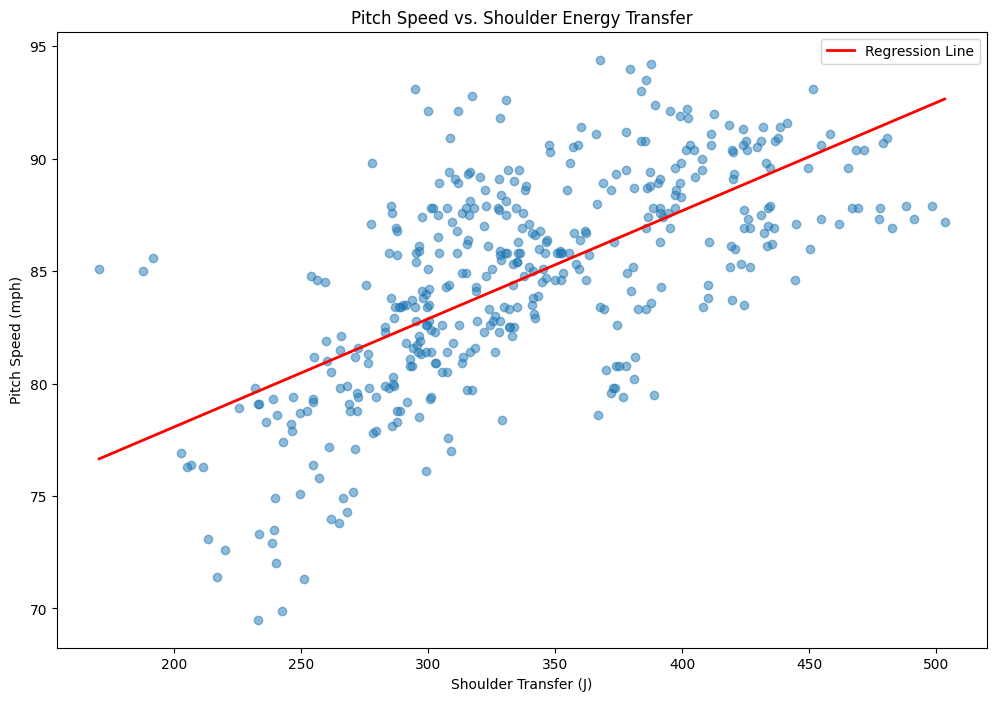


Pearson correlation between Pitch Speed and Shoulder Energy Transfer: 0.65


In [23]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_ind

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BiomechanicalAnalysis/poi_metrics.csv')

# Select columns of interest and drop missing values
cols = ['pitch_speed_mph', 'shoulder_transfer_fp_br']
df = df.dropna(subset=cols)

# Scatter plot with regression line: Shoulder Energy Transfer vs. Pitch Speed
plt.figure(figsize=(12,8))
plt.scatter(df['shoulder_transfer_fp_br'], df['pitch_speed_mph'], alpha=0.5)
plt.xlabel('Shoulder Transfer (J)')
plt.ylabel('Pitch Speed (mph)')
plt.title('Pitch Speed vs. Shoulder Energy Transfer')

# Fit linear regression
x = df['shoulder_transfer_fp_br'].values.reshape(-1, 1)
y = df['pitch_speed_mph'].values
reg = LinearRegression().fit(x, y)
x_line = np.linspace(df['shoulder_transfer_fp_br'].min(), df['shoulder_transfer_fp_br'].max(), 100)
y_line = reg.predict(x_line.reshape(-1, 1))
plt.plot(x_line, y_line, color='red', linewidth=2, label='Regression Line')
plt.legend()
plt.show()

# Calculate Pearson correlation
corr = np.corrcoef(df['pitch_speed_mph'], df['shoulder_transfer_fp_br'])[0, 1]
print(f"\nPearson correlation between Pitch Speed and Shoulder Energy Transfer: {corr:.2f}")

###Corelation results between Pitch Speed and Shoulder Energy Transfer

####This scatter plot illustrates the relationship between pitch speed and shoulder energy transfer, with each blue dot representing an individual pitch and the red line indicating the fitted regression trend. The Pearson correlation coefficient is 0.65, which suggests a moderately strong positive relationship: this indicates that pitchers who effectively generate and transfer energy at the shoulder often achieve higher pitch velocities.







##Box plot
####We separated the high-velocity and low-velocity groups using the median pitch speed as the threshold, and created a box plot.


Median Pitch Speed: 85.30 mph


<ipython-input-20-a633a9d898ff>:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=group_names)


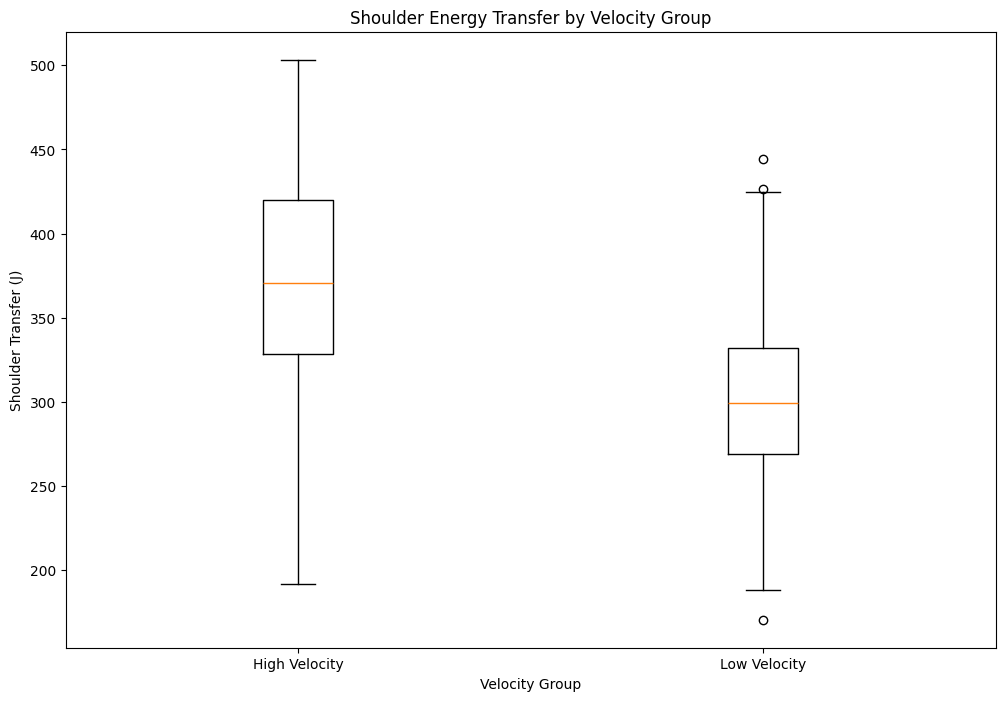

In [20]:
# Define velocity groups based on median pitch speed
median_speed = df['pitch_speed_mph'].median()
df['velocity_group'] = np.where(df['pitch_speed_mph'] >= median_speed, 'High Velocity', 'Low Velocity')
print(f"\nMedian Pitch Speed: {median_speed:.2f} mph")

# Box plot to compare Shoulder Energy Transfer between high and low velocity groups
plt.figure(figsize=(12,8))
groups = df.groupby('velocity_group')['shoulder_transfer_fp_br']
group_names = list(groups.groups.keys())
data_to_plot = [groups.get_group(name) for name in group_names]

plt.boxplot(data_to_plot, labels=group_names)
plt.xlabel('Velocity Group')
plt.ylabel('Shoulder Transfer (J)')
plt.title('Shoulder Energy Transfer by Velocity Group')
plt.show()

####The box plot shows us that the high-velocity group exhibits both a higher median and a higher upper range of shoulder energy transfer, suggesting that pitchers in this group consistently transfer more energy at the shoulder than those in the low-velocity group.


##Validation, Bootstrap analysis
####We'll use a bootstrap analysis (10,000 iterations) to confirm whether the difference in shoulder energy transfer between high-velocity and low-velocity pitchers is significant. This approach repeatedly samples from our data, calculates the difference each time, and produces a reliable estimate of how meaningful this difference really is.



In [15]:
# Additional tests to verify our findings

from scipy.stats import mannwhitneyu
import numpy as np

# ---- Bootstrap Analysis for Difference in Means ----
n_bootstraps = 10000
diff_means = []
high_vals = high_group.values
low_vals = low_group.values
n_high = len(high_vals)
n_low = len(low_vals)

np.random.seed(42)  # For reproducibility
for i in range(n_bootstraps):
    sample_high = np.random.choice(high_vals, size=n_high, replace=True)
    sample_low = np.random.choice(low_vals, size=n_low, replace=True)
    diff_means.append(sample_high.mean() - sample_low.mean())

diff_means = np.array(diff_means)
ci_lower = np.percentile(diff_means, 2.5)
ci_upper = np.percentile(diff_means, 97.5)
print(f"Bootstrap 95% CI for difference in means: [{ci_lower:.2f}, {ci_upper:.2f}]")



Bootstrap 95% CI for difference in means: [60.48, 80.97]


###Our bootstrap results tells us that, on average, high-velocity pitchers transfer about 60.48 to 80.97 Joules more energy through their shoulder compared to low-velocity pitchers.

##Application (Determining the number of pitches with inefficent throw mechanics)
####We'll set two conditions:

####High Shoulder Energy Transfer: The pitch's shoulder energy transfer is above the median (meaning it's in the top 50% of values, not less than 50%). This indicates that the shoulder is working hard.

####Large Negative Residual: The pitch’s residual (actual pitch speed minus predicted pitch speed from our regression) is below the 25th percentile, which here is -2.19 mph. This means the actual speed is at least 2.19 mph lower than what we'd expect given the shoulder energy transfer.


Residual threshold (25th percentile): -2.19 mph
Number of inefficient pitches (residual method): 50 out of 411
Percentage: 12.17%


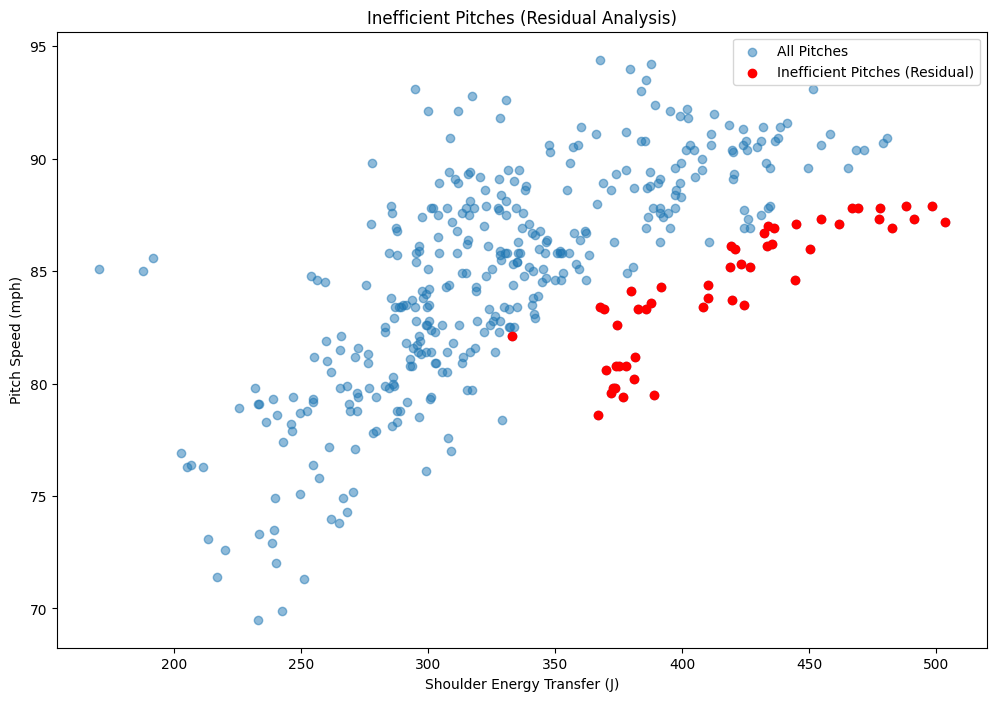

In [21]:
# Fit a linear regression model to predict pitch speed from shoulder energy transfer
x = df['shoulder_transfer_fp_br'].values.reshape(-1, 1)
y = df['pitch_speed_mph'].values
reg = LinearRegression().fit(x, y)
predicted_speed = reg.predict(x)

# Compute residuals (observed - predicted)
df['residual'] = df['pitch_speed_mph'] - predicted_speed

# Define a threshold for inefficiency: for example, pitches with residuals in the bottom 25% (i.e., most negative)
residual_thresh = df['residual'].quantile(0.25)
print(f"Residual threshold (25th percentile): {residual_thresh:.2f} mph")

# Optionally, we can also require shoulder energy transfer be above its median to focus on high-load cases.
shoulder_median = df['shoulder_transfer_fp_br'].median()

inefficient_pitches_resid = df[
    (df['residual'] < residual_thresh) &
    (df['shoulder_transfer_fp_br'] > shoulder_median)
]

num_inefficient_resid = inefficient_pitches_resid.shape[0]
print(f"Number of inefficient pitches (residual method): {num_inefficient_resid} out of {total_pitches}")
print(f"Percentage: {100 * num_inefficient_resid / total_pitches:.2f}%")

# Plot the results
plt.figure(figsize=(12,8))
plt.scatter(df['shoulder_transfer_fp_br'], df['pitch_speed_mph'], alpha=0.5, label='All Pitches')
plt.scatter(inefficient_pitches_resid['shoulder_transfer_fp_br'], inefficient_pitches_resid['pitch_speed_mph'],
            color='red', label='Inefficient Pitches (Residual)')
plt.xlabel('Shoulder Energy Transfer (J)')
plt.ylabel('Pitch Speed (mph)')
plt.title('Inefficient Pitches (Residual Analysis)')
plt.legend()
plt.show()


##Results
####Depending on the thresholds used, the number of inefficient pitches can vary. In our dataset, we identified 50 pitches (12.17% of the total) where the pitcher shows high shoulder energy transfer but achieves a pitch speed significantly lower than predicted. This indicates that, despite a strong shoulder effort, the energy is not effectively transmitted through the kinetic chain. Possible reasons may include poor timing, suboptimal coordination, underperformance in the lower body or trunk, or compensatory mechanics that over-rely on the shoulder.

####Over time, this excess load on the shoulder could increase the risk of overuse injuries. This analysis helps highlight when pitchers might be overusing their shoulder, enabling early intervention to address mechanical inefficiencies and reduce potential injury risks.
